In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr

# functions

In [288]:
def get_path_holfuy(station, format=None):
    if format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\'
        filename = str(station)+'_abl_sum.csv'
        path = os.path.join(folder, filename)
        return path

    elif format=='standard_point':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\holfuy_manual_readings_2020\\'
        if station==1001 or station==1008:
            filename = 'findelen_intermediate.dat'
        elif station==1002 or station==1006 or station==1007:
            filename = 'rhone_intermediate.dat'
        elif station==1003:
            filename = 'plainemorte_intermediate.dat'

        path = os.path.join(folder, filename)
        return path


def get_path_clim(station):
    if station == 1008:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_200.dat'
    elif station == 1001:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_700.dat'
    elif station == 1003:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_plm_P6.dat'
    elif station == 1007:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P5.dat'
    elif station == 1002:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P6.dat'
    elif station == 1006:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P8.dat'
    return path


def import_climatology(path):
    head = pd.read_csv(
        path, sep=';', skiprows=2, skipinitialspace=True,
        header=0, nrows=0, encoding='latin1').columns

    usecols = np.arange(len(head))
    colnames = head
    climatology = pd.read_csv(path,
                           skiprows=4, sep=' ', skipinitialspace=True,
                           usecols=usecols, header=None,
                           names=colnames, dtype={'date_s': str,
                                                  'date_f': str,
                                                  'date0': str,
                                                  'date1': str})
    climatology.columns = climatology.columns.str.rstrip()
    climatology.columns = climatology.columns.str.replace('# ', '')
    climatology = climatology.drop_duplicates()
    return climatology


def import_holfuy(fpath=None, station=None, year=None, ice_only=True, exclude_keywords=True, format=None):
    """

    Parameters
    ----------
    fpath
    ice_only
    exclude_keywords
    format: standard: original format from johannes

    Returns
    -------

    """
    if not fpath:
        fpath = get_path_holfuy(station, format)
    if format=='standard_csv':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0])

        # exclude some of the critical days
        if exclude_keywords:
            cread = cread[~cread.key_remarks.str.contains("SETUP", na=False)]
            # cread = cread[~cread.key_remarks.str.contains("REDRILL", na=False)]
            cread = cread[~cread.key_remarks.str.contains("TEARDOWN", na=False)]

        if ice_only:
            cread = cread[cread.phase == 'i']  # exclude snow

        return cread

    elif format=='standard_point':
        head = pd.read_csv(
            fpath, sep=';', skiprows=1, skipinitialspace=True,
            header=0, nrows=0, encoding='latin1').columns
        usecols = np.arange(len(head))
        colnames = head
        df = pd.read_csv(fpath,
                         skiprows=4, sep=' ', skipinitialspace=True,
                         usecols=usecols, header=None,
                         names=colnames, dtype={'date0': str,
                                                'date1': str})
        df.columns = df.columns.str.rstrip()
        df.columns = df.columns.str.replace('# ', '')
        df = df.drop_duplicates()
        # manual remove error in the glazioarch files
        try:
            if df.loc[269]['name']=='HF1008':
                df = df.drop(index=269)
        except:
            pass

        if not station:
            df = df[df['name'].str.contains('|'.join('HF'))]
        else:
            df = df[df['name'].str.contains('HF'+str(station))]
        selection = df[['date0', 'date1', 'mb_we']]

        date0 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date0'].values]
        date1 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date1'].values]
        selection = selection.assign(date0=date0)
        selection = selection.assign(date1=date1)

        selection = selection[['date0', 'date1', 'mb_we']]
        if year is not None:
            selection = selection[selection['date0'].dt.year == year]
        return selection

    elif format=='csv_2021':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='winter':
        cread = pd.read_excel(fpath, index_col=None)#, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='mh_2021':
        #path_mh = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1001_p700_holfuy2021.xlsx'
        holfuy_mh = pd.read_excel(fpath, index_col=None, skiprows=8, usecols=[0, 6], names=['date', 'mb[m.w.e]'])
        holfuy_mh = holfuy_mh.loc[holfuy_mh['date'].notnull()]
        holfuy_mh['mb[m.w.e]'] = holfuy_mh['mb[m.w.e]']/100
        return holfuy_mh
    else:
        return None
    
    
def interpolate_holfuy_df(df, mode=None):
    if mode is not None:
        time = np.arange(df['date'].values[0], df['date'].values[-1])
    else:
        time = np.arange(df['date'].values[0], df['date'].values[-1], dt.timedelta(days=1))
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df['date'].values:
            not_yet_interpolated_holfuy.append(df[df['date'] == t]['mb[m.w.e]'].values[0])
        else:
            not_yet_interpolated_holfuy.append(np.nan)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    if interpolated_df['mb[m.w.e]'].isnull().values.any():
        interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].interpolate(axis=0)
    return interpolated_df    


def get_mb_beg_year_to_holfuy_period(df, station, year):
    if year == 2021:
        return 0
    else:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
        mb_begin_df = pd.read_excel(path)
        indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
        # droping mutiple rows based on column value
        mb_begin_df = mb_begin_df.drop(indexes)
        date = mb_begin_df['date'].values[0]
        mb = mb_begin_df['mb[m.w.e]'].values[0]
        #print(date, mb)
        shift = mb - df[df['date']==date]['mb[m.w.e]'].values[0]
        return shift

    
def get_date_last_meas(station, year):
    path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
    mb_begin_df = pd.read_excel(path)
    indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
    # droping mutiple rows based on column value
    mb_begin_df = mb_begin_df.drop(indexes)
    date = mb_begin_df['date_meas'].values[0]
    return date


def get_mb_last_meas_to_end(station, date):
    clim = import_climatology(get_path_clim(station))
    date = date.astype('datetime64[s]')
    date = date.astype(dt.datetime)
    clim = clim[clim['Hyd.year'] == date.year]
    mb_3009 = clim['balance(b)'].values[-1]
    clim = clim[clim['Month'] == date.month]
    clim = clim[clim['Day'] == date.day]
    mb_measure_day = clim['balance(b)'].values[0]

    mb_last_measure_to_end  = mb_3009 - mb_measure_day
    #print(mb_last_measure_to_end)
    return mb_last_measure_to_end

    
def cut_clim_to_holfuy_period(clim_df, holfuy_df):
    first_date = np.min(holfuy_df['date'])
    last_date = np.max(holfuy_df['date'])
    indexes = clim_df[(clim_df['year'] < first_date.year)
                        | (clim_df['Month'] < first_date.month)
                        | (clim_df['Month'] == first_date.month) & (clim_df['Day'] < first_date.day)
                        | (clim_df['Month'] > last_date.month)
                        | (clim_df['Month'] == last_date.month) & (clim_df['Day'] > last_date.day)].index
    # droping mutiple rows based on column value
    clim_df = clim_df.drop(indexes)
    holfuy_df = holfuy_df[holfuy_df['date']<=dt.datetime(year=first_date.year, month=9, day=30)]
        
    return clim_df, holfuy_df


def get_bias(station, year, visualize=True):
    # holfuy
    if year == 2021:
        holfuy = import_holfuy(station=station, format='csv_2021')
        xtime_h = holfuy['date'].values
        rounded = xtime_h.astype('datetime64[s]')
        xtime_h = [x.astype(dt.datetime) for x in rounded]
        cum_mb = holfuy['mb[m.w.e]'].values
        holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    else:
        holfuy = import_holfuy(station=station, year=year, format='standard_point')
        xtime_h = holfuy['date1'].values
        cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
        holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    clim = clim[clim['Hyd.year'] == year]
    
    #if year != 2019:
    #    date_last_measure = get_date_last_meas(station, year)
    #    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    #    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end
    
    # interpolate holfuy data to have values every day
    interpolated_df = interpolate_holfuy_df(holfuy_new)
    
    #if year != 2019:
    #mb_begin_season = get_mb_beg_year_to_holfuy_period(interpolated_df, station, year)
    #interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + mb_begin_season
    
    # cut clim to match the length of holfuy data
    clim_cutted, interpolated_df = cut_clim_to_holfuy_period(clim, interpolated_df)

    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
    
    clim_corr, delta_grad = correct_slope_bias(clim_cutted, interpolated_df)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    
    mean_bias_y = np.nanmean(bias_y)
    name, color = station_name(station)
    
    if visualize:
        fig, ax = plt.subplots(figsize=(10, 7))
        fig.text(0.25, 0.13, 'mean bias: ' + str(round(mean_bias_y, 3)) + ' m.w.e')
        ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
        ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]'], marker='x', color='black', s=10)
        ax.plot(interpolated_df['date'].values, clim_corr['balance(b)'].values / 1000, label='model corr', color='tab:green')
        ax.plot(interpolated_df['date'].values, clim_cutted['balance(b)'].values / 1000, label='model raw', color='tab:red')
        ax.plot(interpolated_df['date'].values, bias_y, label='bias', color='tab:red')
        ax.fill_between(interpolated_df['date'].values, bias_y, alpha=0.3, color='tab:red')
        plt.legend()
        plt.title(name + ' year: ' + str(year))
        plt.suptitle('MODEL VS HOLFUY', fontweight="bold")
        plt.xlabel('Time')
        plt.ylabel('Mass Balance [m.w.e]')
        plt.show()
    return clim_corr, interpolated_df, mean_bias_y, delta_grad


def get_bias_clim(station, year, visualize=True, mean_slope_bias=None, d0=None, d1=None):
    if year == 2021:
        holfuy = import_holfuy(station=station, format='csv_2021')
        xtime_h = holfuy['date'].values
        rounded = xtime_h.astype('datetime64[s]')
        xtime_h = [x.astype(dt.datetime) for x in rounded]
        xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
        cum_mb = holfuy['mb[m.w.e]'].values
        holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    else:
        holfuy = import_holfuy(station=station, year=year, format='standard_point')
        xtime_h = holfuy['date1'].values
        rounded = xtime_h.astype('datetime64[s]')  #
        xtime_h = [x.astype(dt.datetime) for x in rounded]  #
        xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
        cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
        holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    
    clim_std = clim.groupby(['DOY']).std().reset_index()  #
    clim = clim.groupby(['DOY']).mean().reset_index()  #
    interpolated_df = interpolate_holfuy_df(holfuy_new, mode='DOY')  #
    
    if year==2019 and station==1002:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1006:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1007:
        n = 1
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    else:
        pass

    first_date = np.min(interpolated_df['date'])
    last_date = np.max(interpolated_df['date'])
    
    if d0 is not None and d0 >= first_date:
        first_date = d0 
    if d1 is not None and d1<= last_date:
        last_date = d1
            
    indexes = clim[(clim['DOY'] < first_date) | (clim['DOY'] > last_date)].index  #
    indexes_h = interpolated_df[(interpolated_df['date'] < first_date) | (interpolated_df['date'] > last_date)].index

    # droping mutiple rows based on column value
    clim_cutted = clim.drop(indexes)
    clim_std_cutted = clim_std.drop(indexes)
    interpolated_df = interpolated_df.drop(indexes_h)
    
    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
 
    clim_corr = clim_cutted.copy()
    if mean_slope_bias is not None:
        clim_corr['balance(b)'] = clim_corr['balance(b)'].values + mean_slope_bias*1000*np.arange(len(clim_corr['balance(b)'].values))
    

    
    interpolated_df['rate'] = interpolated_df['mb[m.w.e]'] - interpolated_df['mb[m.w.e]'].shift(1)
    interpolated_df = interpolated_df.dropna()
    clim_corr['rate_b'] = clim_corr['balance(b)'] - clim_corr['balance(b)'].shift(1)
    clim_corr = clim_corr.dropna()
    #print(interpolated_df, clim_corr)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    bias_rate = interpolated_df['rate'].values - clim_corr['rate_b'].values / 1000
    bias_perc = bias_rate/(clim_corr['rate_b'].values / 1000)
    
    name, color = station_name(station)
    
    if visualize:
        if bias_only:
            if plot_rate:
                ax1.plot(clim_corr['DOY'].values, bias_rate,
                         label=name, color=color)
                ax1.fill_between(clim_corr['DOY'].values, bias_rate, color=color, alpha=0.05)
            else:
                ax1.plot(clim_corr['DOY'].values, np.cumsum(bias_rate),
                         label=name, color=color)
                ax1.fill_between(clim_corr['DOY'].values, np.cumsum(bias_rate), color=color, alpha=0.05)
        else:
            if plot_rate:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['rate'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['rate'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['rate_b'].values / 1000, label='climatology', color='tab:green')
                #ax.fill_between(clim_corr['DOY'].values, (clim_corr['rate_b'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                #                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_rate, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:red')
                ax.fill_between(clim_corr['DOY'].values, bias_rate, color='tab:red', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance Rate [m.w.e d -1]')
                plt.legend()
                plt.show()
            else:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['balance(b)'].values / 1000, label='climatology', color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, (clim_corr['balance(b)'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_y, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, bias_y, color='tab:green', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance [m.w.e]')
                plt.legend()
                plt.show()
    #print(bias_rate)
    return bias_rate


def correct_slope_bias(clim_df, holfuy_df):
    mb_grad_clim = (clim_df['balance(b)'].iloc[-1] - clim_df['balance(b)'].iloc[0])/(1000*len(clim_df['balance(b)'].values))
    mb_grad_holfuy = (holfuy_df['mb[m.w.e]'].iloc[-1] - holfuy_df['mb[m.w.e]'].iloc[0])/len(holfuy_df['mb[m.w.e]'].values)
    delta_grad = mb_grad_holfuy - mb_grad_clim
    print('bias slope: ', delta_grad)
    clim_corr = clim_df.copy()
    clim_corr['balance(b)'] = clim_corr['balance(b)'].values + delta_grad*1000*np.arange(len(clim_corr['balance(b)'].values))
    return clim_corr, delta_grad

def station_name(station):
    if station == 1001:
        name = 'FIN top'
        color = 'darkred'
    if station == 1008:
        name = 'FIN bot.'
        color = 'salmon'
    if station == 1003:
        name = 'PLM'
        color = 'gold'
    if station == 1002:
        name = 'RHO bot.'
        color = 'lightskyblue'
    if station == 1006:
        name = 'RHO mid.'
        color = 'royalblue'
    if station == 1007:
        name = 'RHO top'
        color = 'darkblue'
    return name, color

# Main 1
    . get vertical bias between model and modelled year
    . plot bias between climatology and holfuy
    . compares all biases

In [ ]:
bias_only= False
years = [2020]
# attention order of the paths resp stations must agre!!!
#paths = [path_climf2]#, path_climf7, path_climr5, path_climr6, path_climr8, path_climp6]
stations = [1001]#, 1001, 1007, 1002, 1006, 1003]
bias = []

if bias_only:
    fig1, ax1 = plt.subplots(figsize=(10, 7))

for station in stations:
    for year in years:
        if bias_only:
            get_bias_clim(station, year)
        else:
            #get_bias_clim(station, year)
            bias_y = get_bias(station, year, visualize=True)
            bias.append(bias_y)
    print(bias, np.mean(bias))
if bias_only:
    plt.xlabel('Day of Year')
    plt.ylabel('Mass Balance [m.w.e]')
    plt.legend()
    plt.show()

# Main 2

bias slope:  -0.0029285714285714193


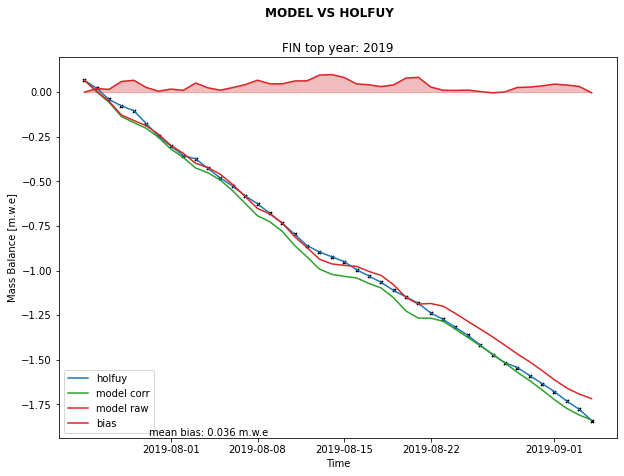

bias slope:  0.00891666666666666


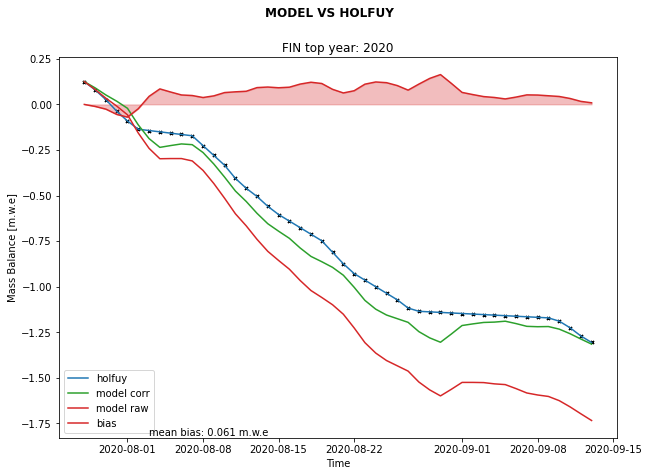

bias slope:  -0.002880051566037725


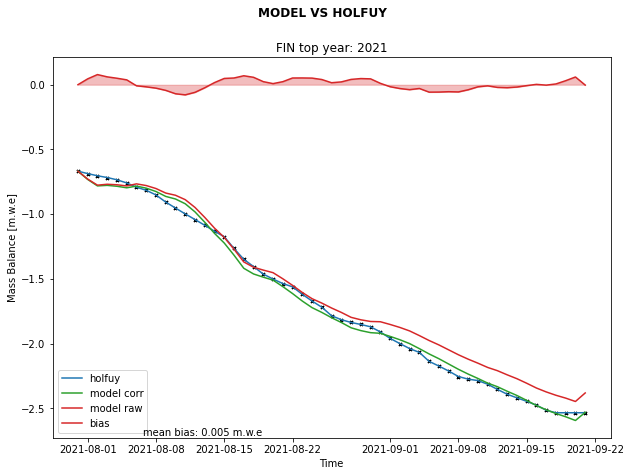

0.0010360145573525051
bias slope:  0.007587500000000011


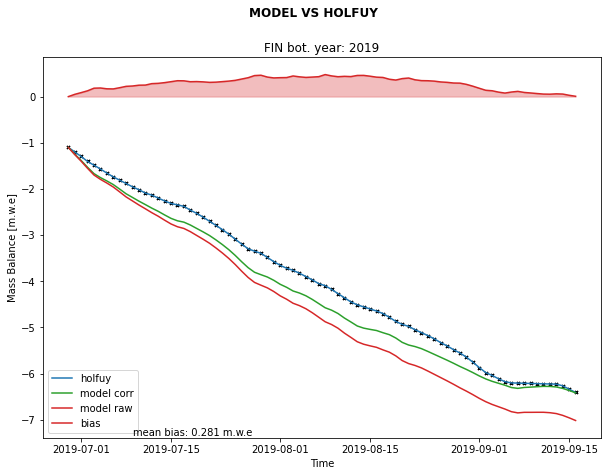

bias slope:  0.010045454545454566


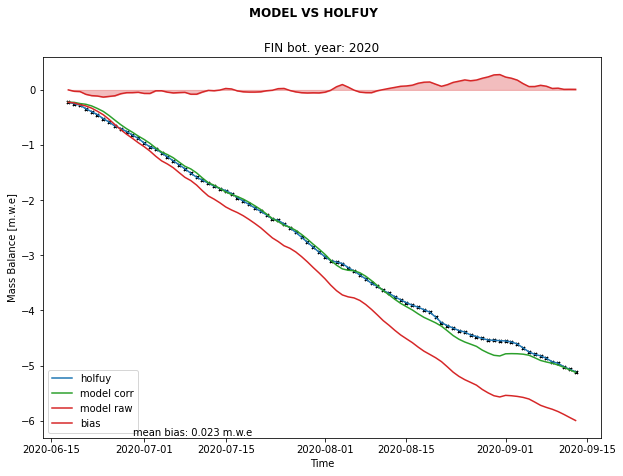

bias slope:  0.006215475363636362


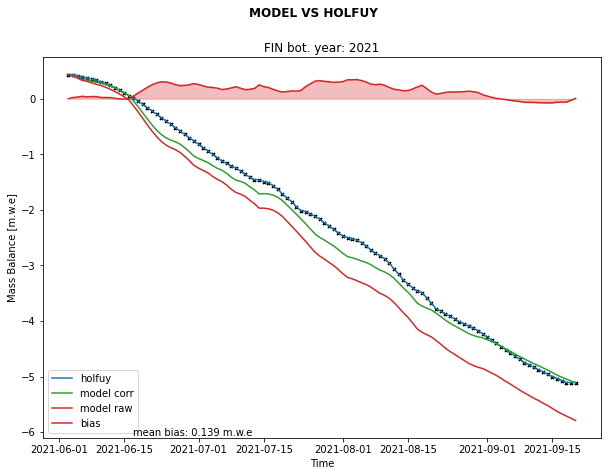

0.004492745596858075
bias slope:  0.0008974358974359019


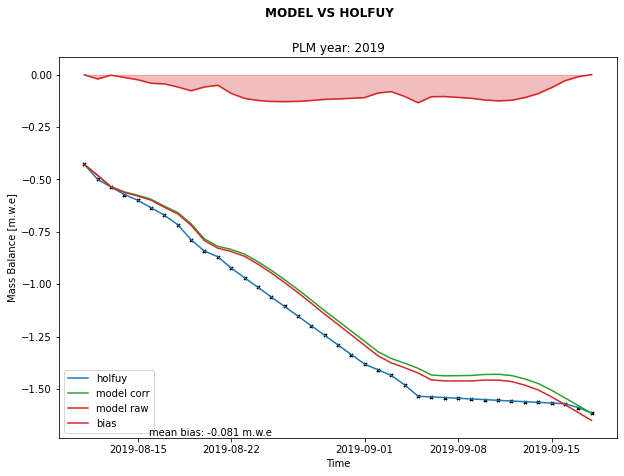

bias slope:  0.01690909090909091


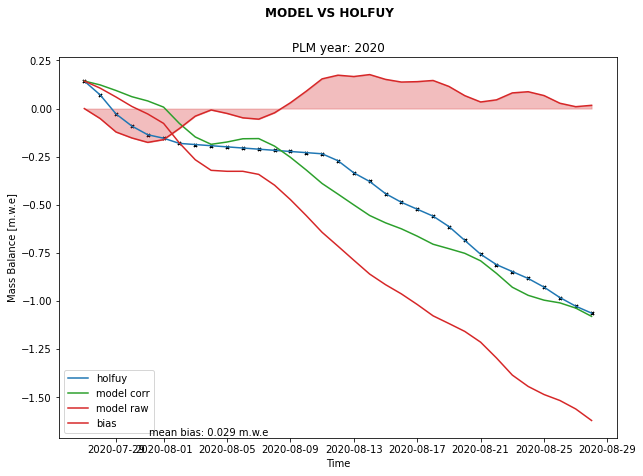

bias slope:  -0.0029702828518518506


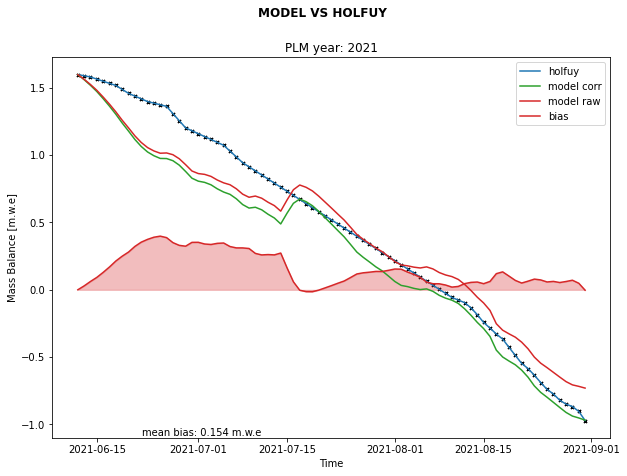

0.004643635281758157
bias slope:  -0.013703124999999997


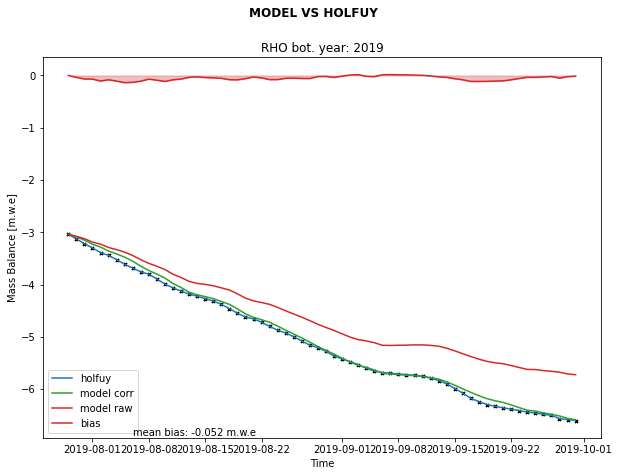

bias slope:  -0.0015454545454545096


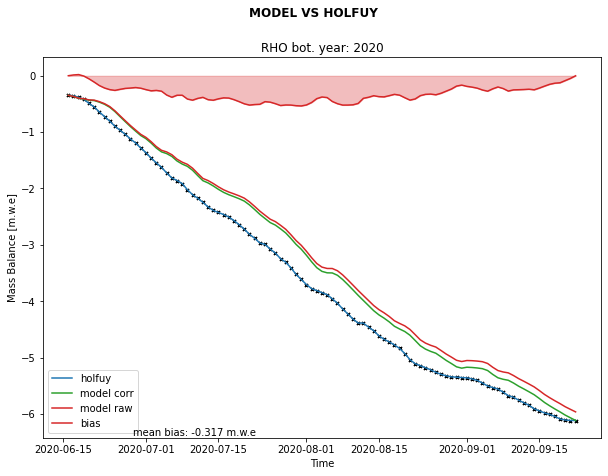

bias slope:  -0.005428998580645161


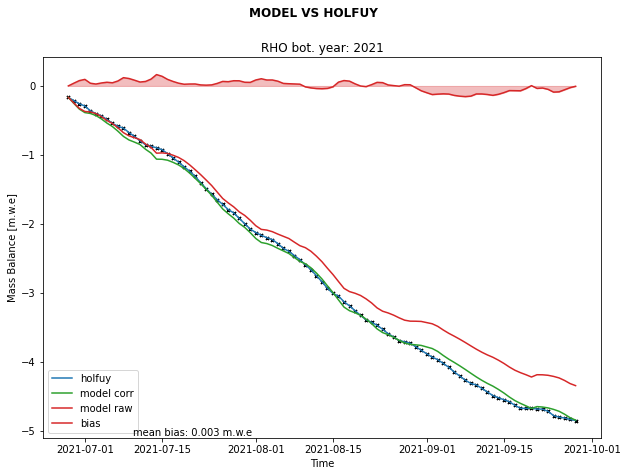

0.0017595949508103122
bias slope:  0.0024347826086956598


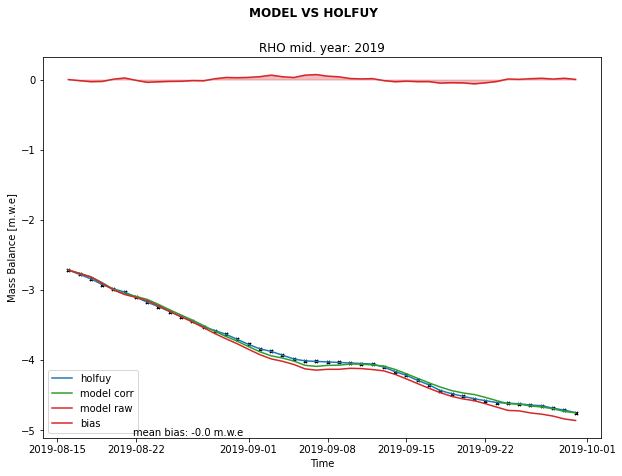

bias slope:  0.0015353535353535425


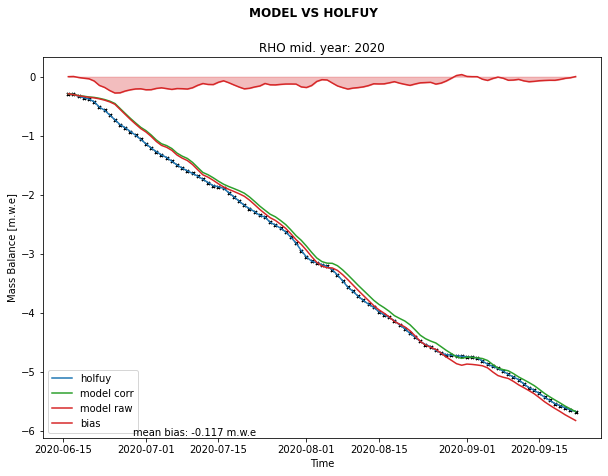

bias slope:  -0.0047796198260869616


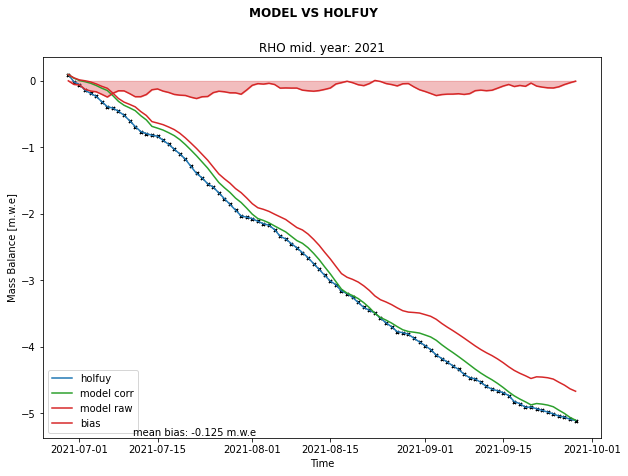

0.0013537103818457325
bias slope:  0.004187500000000018


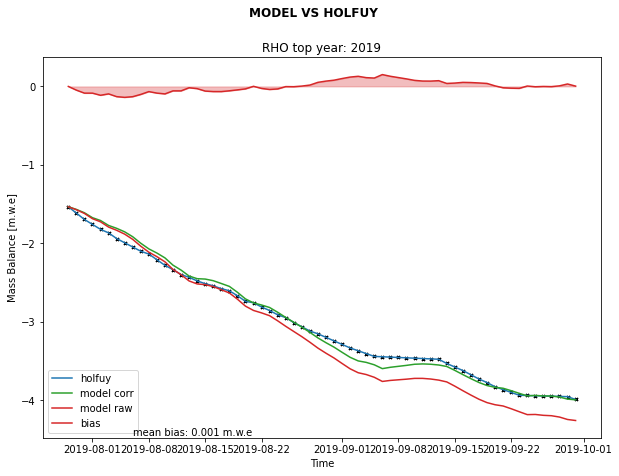

bias slope:  0.00037288135593220584


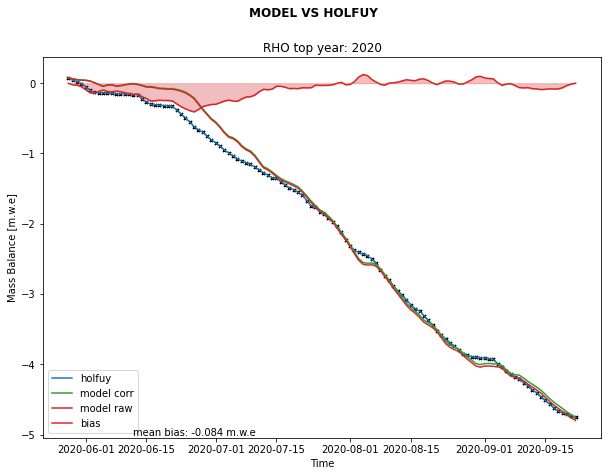

bias slope:  0.005509086249999996


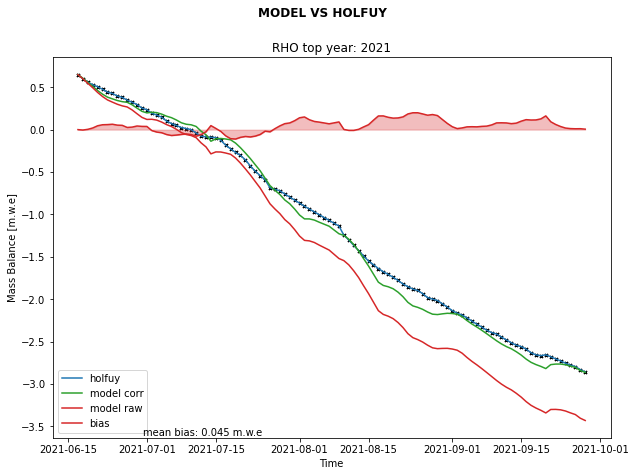

0.001687506851867678
   station  slope_bias
0     1001    0.001036
1     1008    0.004493
2     1003    0.004644
3     1002    0.001760
4     1006    0.001354
5     1007    0.001688


In [157]:
global fig1, ax1, plot_rate

bias_only= True

years = [2019, 2020, 2021]
stations = [1001, 1008, 1003, 1002, 1006, 1007]

slope_bias = []
station_bias = []
for station in stations:
    for year in years:
        clim_cutted, interpolated_df, mean_bias_y, delta_grad = get_bias(station, year, visualize=True)
        slope_bias.append(delta_grad)
    mean_slope_bias = np.nanmean(slope_bias)
    print(mean_slope_bias) 
    station_bias.append(mean_slope_bias)
bias_df = pd.DataFrame({'station': stations, 'slope_bias': station_bias})
print(bias_df)


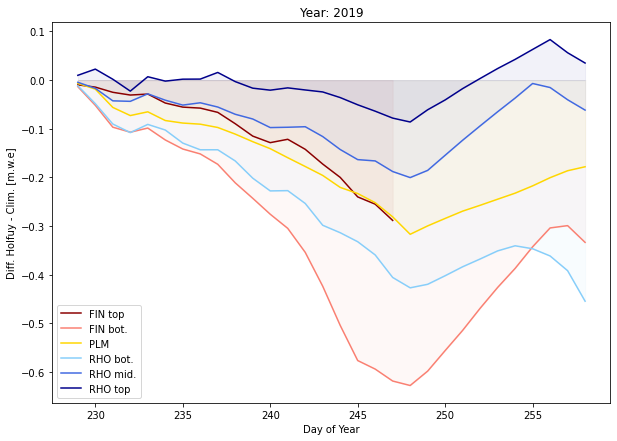

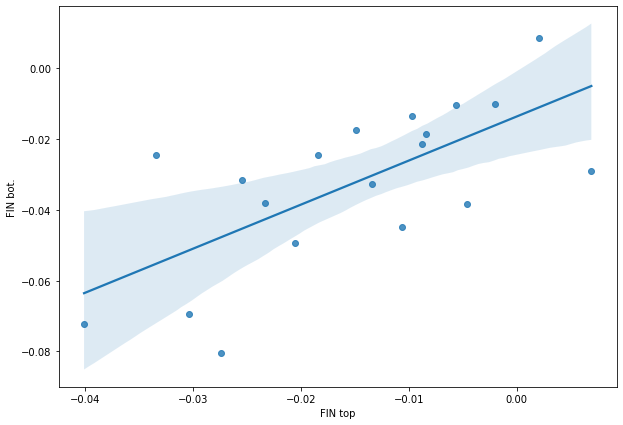

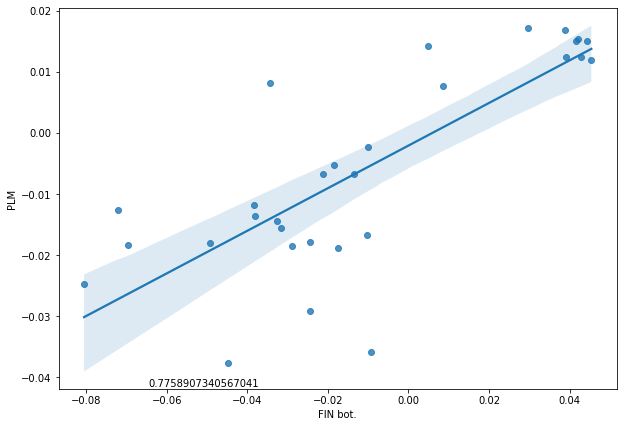

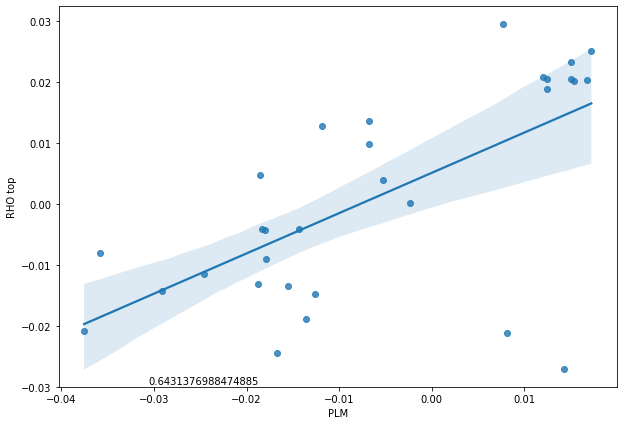

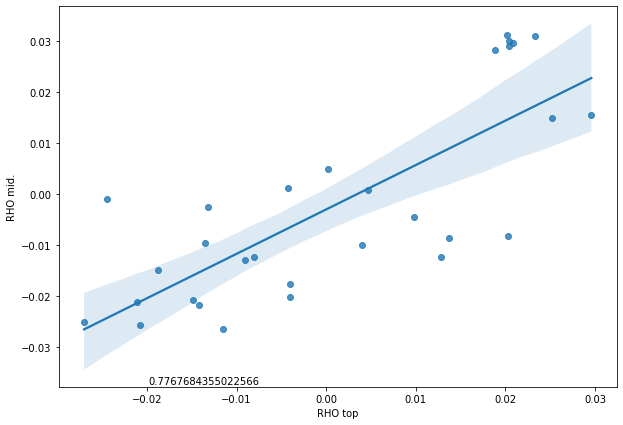

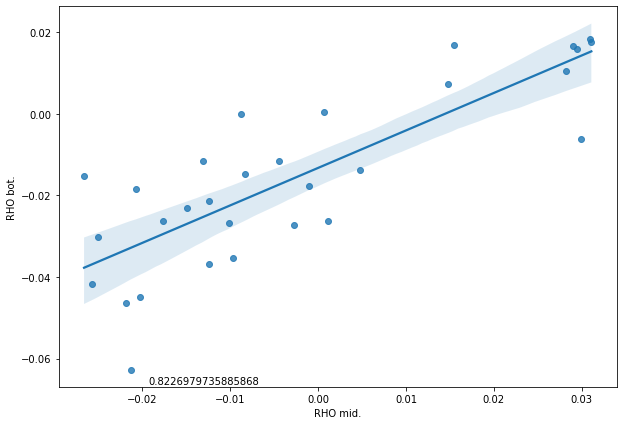

(6, 6)
[[False  True  True  True  True  True]
 [False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False False  True]
 [False False False False False False]]


<AxesSubplot:>

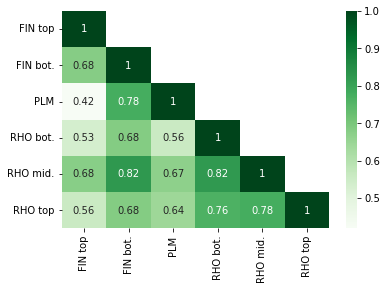

In [307]:
plot_rate = False
bias_only = True
years = [2019]
d0 = 228
d1 = 258

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
for i, name in enumerate(names):
    fig, ax = plt.subplots(figsize=(10, 7)) 
    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
    try:
        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
        fig.text(0.25, 0.13, r)
    except:
        pass
    plt.show()
    if i==len(names)-2:
        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', annot=True)

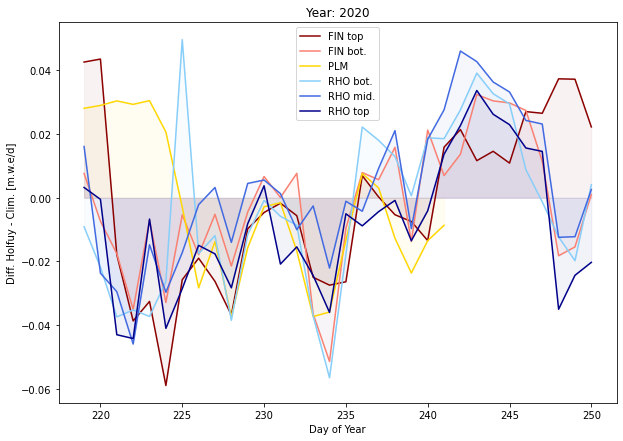

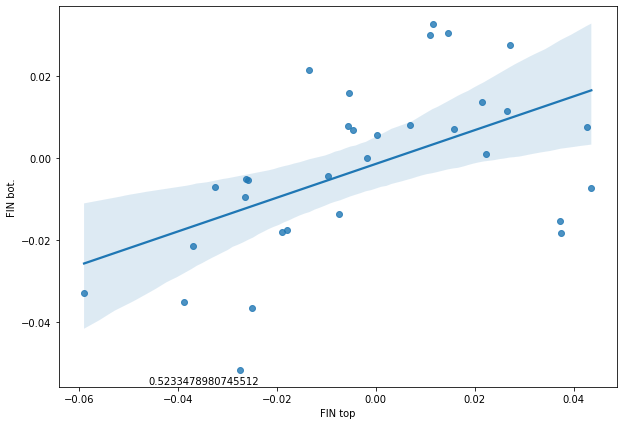

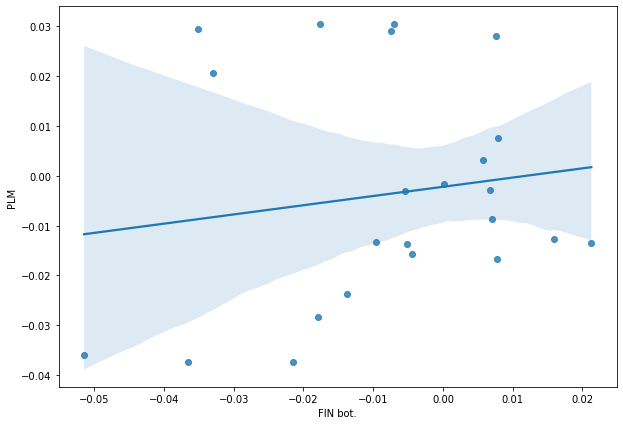

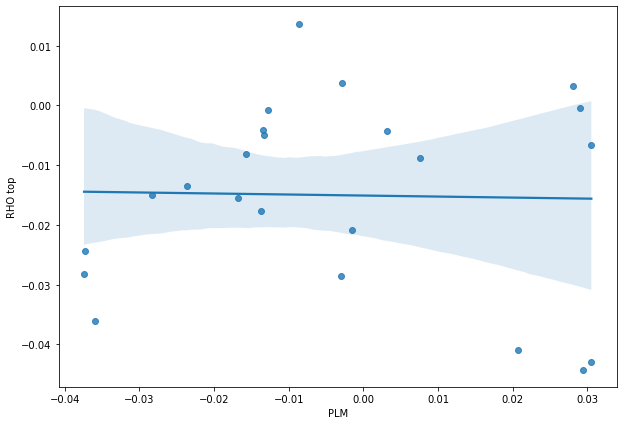

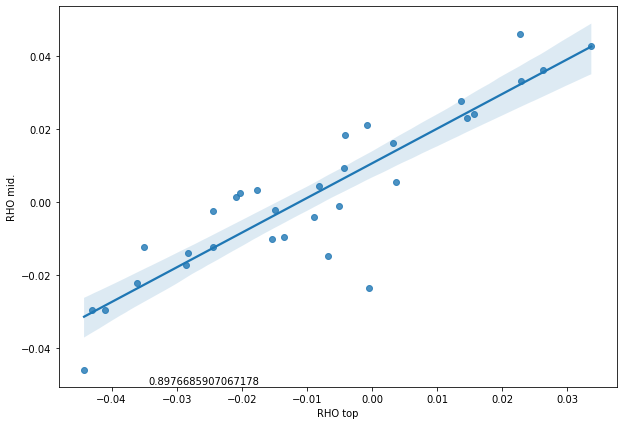

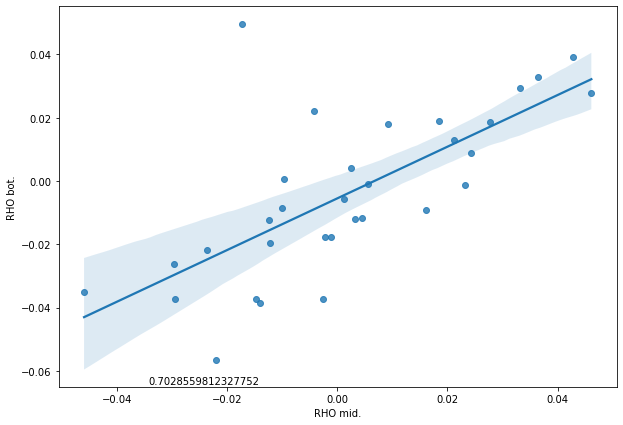

<AxesSubplot:>

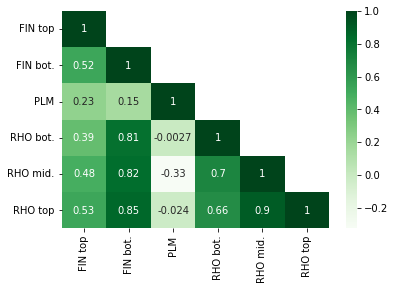

In [308]:
plot_rate = True
bias_only = True
years = [2020]
d0 = 218
d1 = 250

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
for i, name in enumerate(names):
    fig, ax = plt.subplots(figsize=(10, 7)) 
    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
    try:
        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
        fig.text(0.25, 0.13, r)
    except:
        pass
    plt.show()
    if i==len(names)-2:
        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', annot=True)

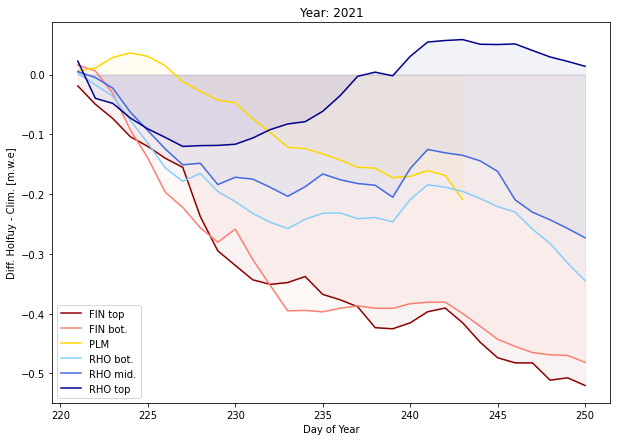

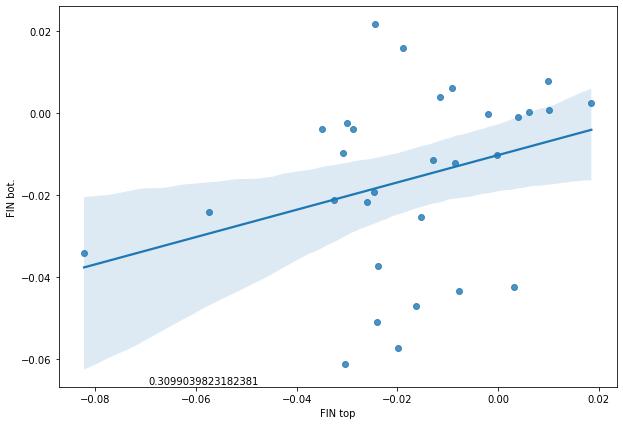

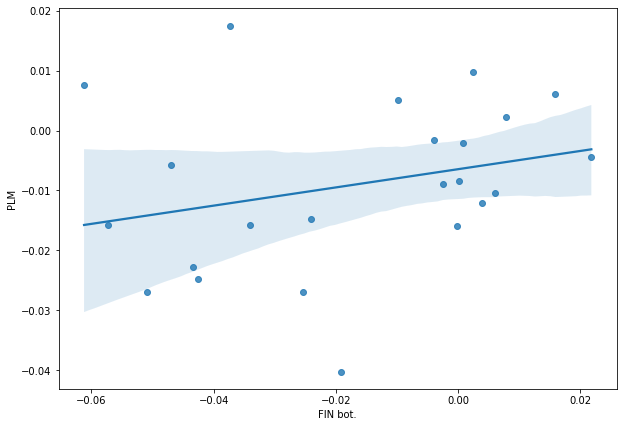

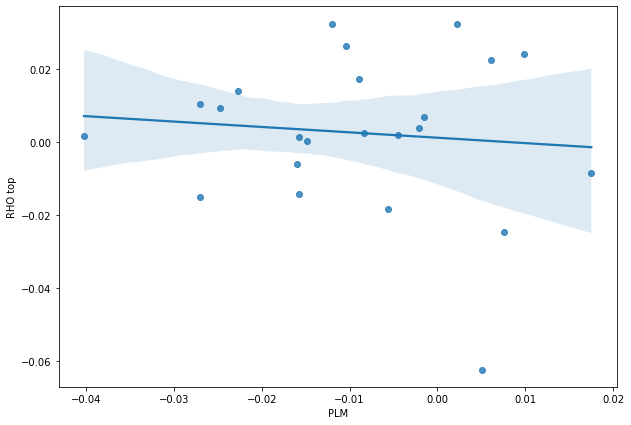

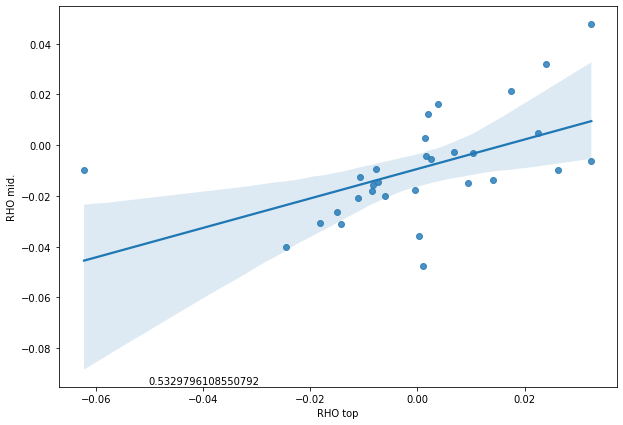

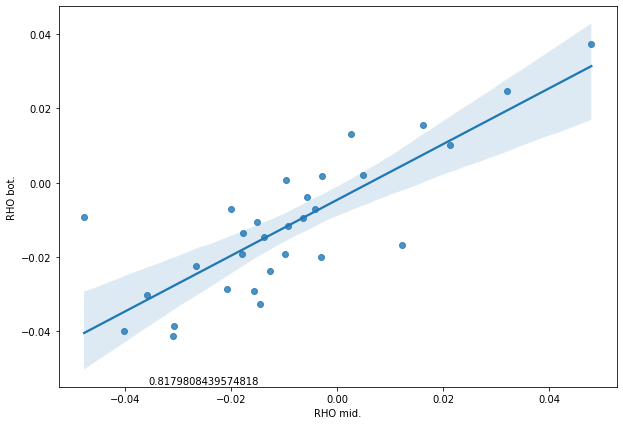

<AxesSubplot:>

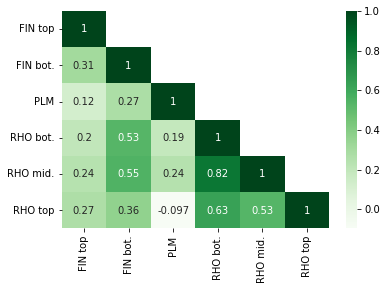

In [309]:
plot_rate = False
bias_only = True
years = [2021]
d0 = 220
d1 = 250

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
for i, name in enumerate(names):
    fig, ax = plt.subplots(figsize=(10, 7)) 
    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
    try:
        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
        fig.text(0.25, 0.13, r)
    except:
        pass
    plt.show()
    if i==len(names)-2:
        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', annot=True)

0       NaN
1    -0.045
2    -0.063
3    -0.036
4    -0.027
5    -0.072
6    -0.072
7    -0.054
8    -0.054
9    -0.018
10   -0.054
11   -0.054
12   -0.045
13   -0.054
14   -0.045
15   -0.054
16   -0.054
17   -0.063
18   -0.063
19   -0.036
20   -0.027
21   -0.027
22   -0.045
23   -0.036
24   -0.036
25   -0.045
26   -0.036
27   -0.036
28   -0.054
29   -0.036
30   -0.045
31   -0.045
32   -0.054
33   -0.054
34   -0.045
35   -0.027
36   -0.045
37   -0.045
38   -0.045
39   -0.054
40   -0.045
41   -0.063
Name: rate, dtype: float64
0       NaN
1    -0.090
2    -0.090
3    -0.081
4    -0.090
      ...  
59   -0.027
60   -0.018
61   -0.063
62   -0.018
63   -0.018
Name: rate, Length: 64, dtype: float64
0          NaN
1    -0.072000
2    -0.036000
3    -0.036000
4    -0.027000
5    -0.036000
6    -0.036000
7    -0.045000
8    -0.072000
9    -0.054000
10   -0.027000
11   -0.054000
12   -0.045900
13   -0.045900
14   -0.045900
15   -0.045900
16   -0.045900
17   -0.045900
18   -0.045900
19   -0.04590

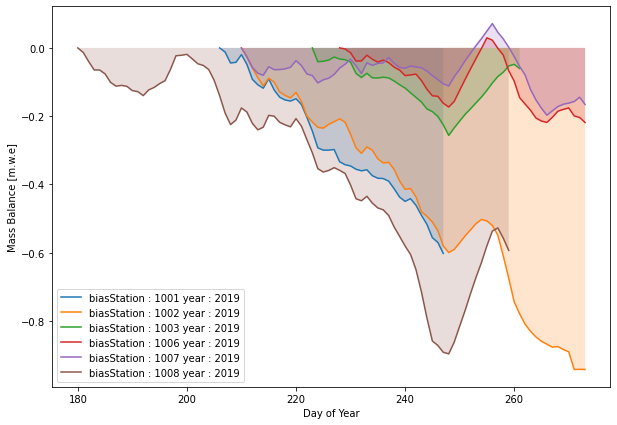

0        NaN
1    -0.0450
2    -0.0540
3    -0.0630
4    -0.0540
5    -0.0450
6    -0.0072
7    -0.0072
8    -0.0072
9    -0.0072
10   -0.0072
11   -0.0540
12   -0.0540
13   -0.0540
14   -0.0720
15   -0.0540
16   -0.0450
17   -0.0540
18   -0.0450
19   -0.0360
20   -0.0360
21   -0.0360
22   -0.0360
23   -0.0630
24   -0.0630
25   -0.0540
26   -0.0360
27   -0.0360
28   -0.0360
29   -0.0360
30   -0.0450
31   -0.0180
32   -0.0030
33   -0.0030
34   -0.0030
35   -0.0030
36   -0.0030
37   -0.0030
38   -0.0030
39   -0.0030
40   -0.0030
41   -0.0030
42   -0.0030
43   -0.0030
44   -0.0180
45   -0.0360
46   -0.0450
47   -0.0360
Name: rate, dtype: float64
0       NaN
1    -0.009
2    -0.027
3    -0.036
4    -0.072
      ...  
94   -0.036
95   -0.045
96   -0.018
97   -0.009
98    0.000
Name: rate, Length: 99, dtype: float64
0       NaN
1    -0.072
2    -0.099
3    -0.063
4    -0.045
5    -0.018
6    -0.027
7    -0.006
8    -0.006
9    -0.006
10   -0.006
11   -0.006
12   -0.006
13   -0.006
14   -0.00

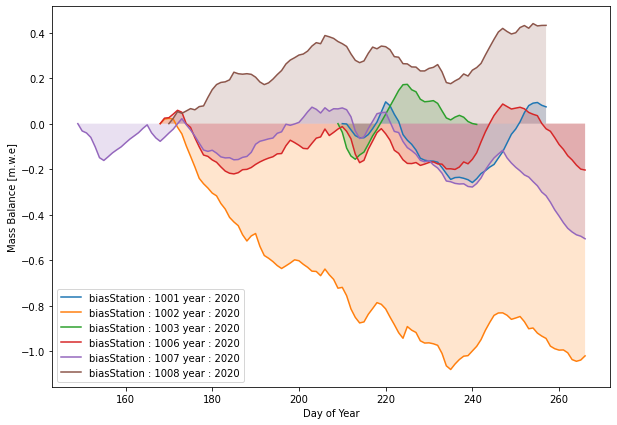

0          NaN
1    -0.018658
2    -0.016883
3    -0.013477
4    -0.017552
5    -0.024303
6    -0.032785
7    -0.024014
8    -0.035958
9    -0.055072
10   -0.046030
11   -0.045366
12   -0.043336
13   -0.044615
14   -0.045817
15   -0.042934
16   -0.090380
17   -0.083655
18   -0.055768
19   -0.058452
20   -0.038068
21   -0.034917
22   -0.025477
23   -0.057516
24   -0.052045
25   -0.047863
26   -0.065676
27   -0.030437
28   -0.021616
29   -0.015355
30   -0.018205
31   -0.039326
32   -0.050153
33   -0.039880
34   -0.038625
35   -0.029771
36   -0.069161
37   -0.036262
38   -0.038137
39   -0.042599
40   -0.020198
41   -0.011129
42   -0.028255
43   -0.039856
44   -0.037352
45   -0.027831
46   -0.026813
47   -0.030147
48   -0.038828
49   -0.019666
50    0.000276
51   -0.000285
52    0.000587
Name: rate, dtype: float64
0          NaN
1    -0.047818
2    -0.045884
3    -0.032728
4    -0.068206
        ...   
88   -0.061748
89   -0.023312
90   -0.012590
91   -0.020031
92   -0.015600
Name: rate, L

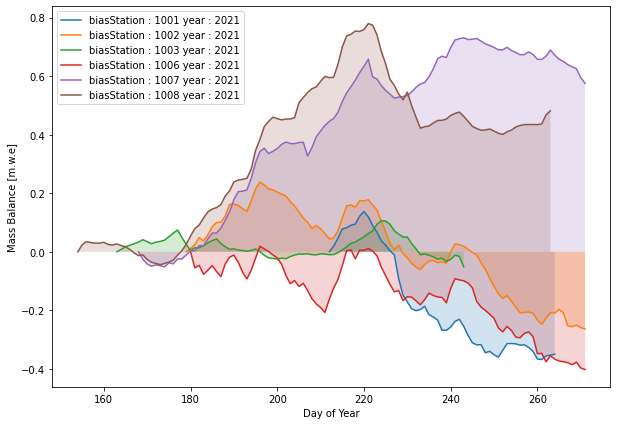

In [9]:
bias_only= True
stations = [1001, 1002, 1003, 1006, 1007, 1008]

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        get_bias_clim(station, year, mean_slope_bias)
        

    if bias_only:
        plt.xlabel('Day of Year')
        plt.ylabel('Mass Balance [m.w.e]')
        plt.legend()
        plt.show()